In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from advectionGP.models.mesh_1d_ode_model import AdjointSecondOrderODEModel as Model
from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.wind import WindFixU #Wind model

avg=0.1 # time that an observation is taken for
tlocL = np.linspace(0,9.9,20) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time
sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)
k_0 = -0.5 #Diffusion coefficient
u=1
eta=5
noiseSD = 0.1 #Observation noise
N_feat=50 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(np.sqrt(0.6), 1) # generate EQ kernel arguments are lengthscale and variance
res = [200] # grid size for time

m = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta)

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z) # Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeResponse(sourceGT) # Compute concentration - runs ODE forward model

yTrain= m.computeObservations(addNoise=True) # Compute observations with noise uses m.sensormodel for observation locations
kForward = EQ(np.sqrt(0.6), 1) # generate EQ kernel arguments are lengthscale and variance
mTest = Model(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta)
regressors = mTest.computeModelRegressors() # Compute regressor matrix
meanZ, covZ = mTest.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourceInferred = mTest.computeSourceFromPhi(meanZ) # Generates estimated source using inferred distributio

Calculating Adjoints...
19/20 
Calculating Phis...
49/50 
Computing SS...
Inverting SS...
Computing meanZ
Done


In [2]:
from advectionGP.constraints import NonNegConstraint
nnc = NonNegConstraint(mTest,yTrain,np.linspace(0,5,10)[:,None],thinning=5)
samps = nnc.sample()
print("Checking convergence. Gelman Rubin statistic: (should be less than about 1.2)")
print(nnc.check_convergence(Nchains=5))

Computing SS...
Inverting SS...
Computing meanZ
Done
Checking convergence. Gelman Rubin statistic: (should be less than about 1.2)
1.1149703315573696


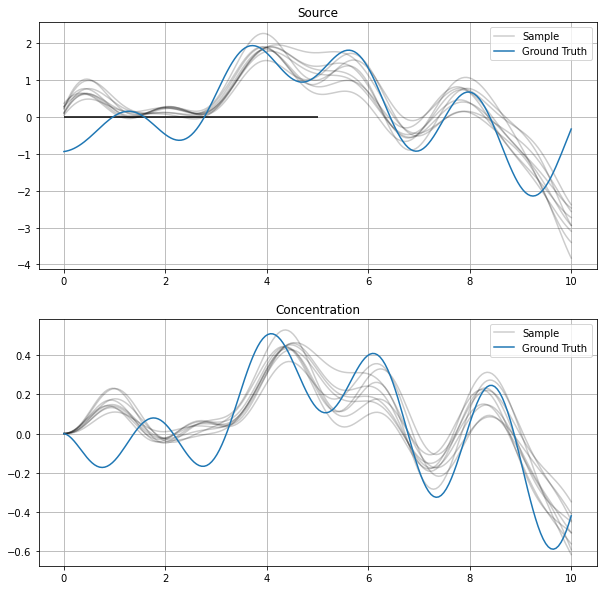

In [3]:
plt.figure(figsize=[10,10])
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
l = 'Sample'
for samp in samps:
    sourceInferred = mTest.computeSourceFromPhi(samp)
    concInferred = mTest.computeResponse(sourceInferred)
    ax1.plot(mTest.coords[0,:],sourceInferred,'-k',alpha=0.2,label=l)    
    ax2.plot(mTest.coords[0,:],concInferred,'-k',alpha=0.2,label=l)
    l = None
ax1.set_title('Source')
ax1.plot(mTest.coords[0,:],sourceGT,label='Ground Truth')
ax1.grid()
ax1.legend()
ax2.set_title('Concentration')
ax2.plot(mTest.coords[0,:],concTrain,label='Ground Truth')
ax2.grid()
ax2.legend()
ax1.hlines(0,0,5)